In [7]:
import pandas as pd

# Load the test data CSV
test_data_path = 'TEST DATA.csv'
test_data = pd.read_csv(test_data_path)

# Load the dictionary Excel file
dictionary_path = 'Dictionary 10.xlsx'
dictionary_data = pd.read_excel(dictionary_path)

# Prepare a dictionary for quick lookup from dictionary data
category_words = {category: set(dictionary_data[category].dropna().str.lower()) for category in dictionary_data.columns}

# Aggregate text by Text-ID
aggregated_text = test_data.groupby('Text-ID')['Text'].apply(' '.join).reset_index()

# Initialize a dataframe to hold the results
result_counts = pd.DataFrame(columns=['Text-ID'] + list(category_words.keys()))
result_counts['Text-ID'] = aggregated_text['Text-ID']
result_counts = result_counts.fillna(0)

# Function to count words from a set in a given text
def count_words_in_text(text, word_set):
    words = text.lower().split()
    return sum(1 for word in words if word in word_set)

# Iterate over the aggregated text data and count occurrences for each category
for _, row in aggregated_text.iterrows():
    text_id = row['Text-ID']
    text = row['Text']
    
    for category, words in category_words.items():
        count = count_words_in_text(text, words)
        result_counts.loc[result_counts['Text-ID'] == text_id, category] += count

# Create a binary DataFrame with the same structure as result_counts
binary_counts = result_counts.copy()
binary_counts.iloc[:, 1:] = 0  # Set all counts to 0 initially

# Iterate over each row to set the highest value to 1
for index, row in result_counts.iterrows():
    highest_category = row[1:].idxmax()
    binary_counts.at[index, highest_category] = 1

# Save the result_counts and binary_counts to Excel files
output_path_counts = 'Word_Counts.xlsx'
output_path_binary = 'Word_Binary.xlsx'

with pd.ExcelWriter(output_path_counts) as writer:
    result_counts.to_excel(writer, index=False, sheet_name='Counts')

with pd.ExcelWriter(output_path_binary) as writer:
    binary_counts.to_excel(writer, index=False, sheet_name='Binary')


In [8]:
import pandas as pd

# Load the provided Excel files
expert_binary_path = 'Expert_binary.xlsx'
word_binary_path = 'Word_Binary.xlsx'

expert_binary = pd.read_excel(expert_binary_path)
word_binary = pd.read_excel(word_binary_path)

# Merge the two dataframes on 'Text-ID'
merged_df = pd.merge(expert_binary, word_binary, on='Text-ID', suffixes=('_expert', '_word'))

# Create new columns
merged_df['Expert Category'] = merged_df.filter(regex='_expert$').idxmax(axis=1).str.replace('_expert', '')
merged_df['Word Category'] = merged_df.filter(regex='_word$').idxmax(axis=1).str.replace('_word', '')
merged_df['Match'] = merged_df['Expert Category'] == merged_df['Word Category']

# Adjust the calculation of match percentage to compare categories rather than words
def calculate_category_match_percentage(expert_category, word_category):
    return 100.0 if expert_category == word_category else 0.0

# Calculate Expert Match % and Word Match %
merged_df['Expert Match %'] = merged_df.apply(lambda row: calculate_category_match_percentage(row['Expert Category'], row['Word Category']), axis=1)
merged_df['Word Match %'] = merged_df.apply(lambda row: calculate_category_match_percentage(row['Word Category'], row['Expert Category']), axis=1)

# Select required columns with correct suffixes
expert_columns = [col for col in merged_df.columns if col.endswith('_expert')]
word_columns = [col for col in merged_df.columns if col.endswith('_word')]
category_columns = [col.replace('_expert', '') for col in expert_columns]

# Prepare the final dataframe
final_df = merged_df[['Text-ID'] + expert_columns + word_columns + ['Expert Category', 'Word Category', 'Match', 'Expert Match %', 'Word Match %']]

# Rename the columns for clarity
final_df.columns = ['Text-ID'] + [f'Expert_{col.replace("_expert", "")}' for col in expert_columns] + \
                   [f'Word_{col.replace("_word", "")}' for col in word_columns] + \
                   ['Expert Category', 'Word Category', 'Match', 'Expert Match %', 'Word Match %']

# Save the final dataframe to a new Excel file
output_path_final = 'Final_Output.xlsx'
final_df.to_excel(output_path_final, index=False)

print(f"Final output saved to {output_path_final}")


Final output saved to Final_Output.xlsx


In [9]:
import pandas as pd

# Load the provided Excel files
expert_binary_path = 'Expert_binary.xlsx'
word_binary_path = 'Word_Binary.xlsx'

expert_binary = pd.read_excel(expert_binary_path)
word_binary = pd.read_excel(word_binary_path)

# Merge the two dataframes on 'Text-ID'
merged_df = pd.merge(expert_binary, word_binary, on='Text-ID', suffixes=('_expert', '_word'))

# Create new columns
merged_df['Expert Category'] = merged_df.filter(regex='_expert$').idxmax(axis=1).str.replace('_expert', '')
merged_df['Word Category'] = merged_df.filter(regex='_word$').idxmax(axis=1).str.replace('_word', '')
merged_df['Match'] = merged_df['Expert Category'] == merged_df['Word Category']

# Adjust the calculation of match percentage to compare categories rather than words
def calculate_category_match_percentage(expert_category, word_category):
    return 100.0 if expert_category == word_category else 0.0

# Calculate Expert Match % and Word Match %
merged_df['Expert Match %'] = merged_df.apply(lambda row: calculate_category_match_percentage(row['Expert Category'], row['Word Category']), axis=1)
merged_df['Word Match %'] = merged_df.apply(lambda row: calculate_category_match_percentage(row['Word Category'], row['Expert Category']), axis=1)

# Select required columns with correct suffixes
expert_columns = [col for col in merged_df.columns if col.endswith('_expert')]
word_columns = [col for col in merged_df.columns if col.endswith('_word')]
category_columns = [col.replace('_expert', '') for col in expert_columns]

# Prepare the final dataframe
final_df = merged_df[['Text-ID'] + expert_columns + word_columns + ['Expert Category', 'Word Category', 'Match', 'Expert Match %', 'Word Match %']]

# Rename the columns for clarity
final_df.columns = ['Text-ID'] + [f'Expert_{col.replace("_expert", "")}' for col in expert_columns] + \
                   [f'Word_{col.replace("_word", "")}' for col in word_columns] + \
                   ['Expert Category', 'Word Category', 'Match', 'Expert Match %', 'Word Match %']

# Calculate total True, False, and Match %
total_true = final_df['Match'].sum()
total_false = len(final_df) - total_true
match_percentage = (total_true / len(final_df)) * 100

# Print out the totals and match percentage
print(f"Total True: {total_true}")
print(f"Total False: {total_false}")
print(f"Overall Match Percentage: {match_percentage:.2f}%")

# Save the final dataframe to a new Excel file
output_path_final = 'Final_Output.xlsx'
final_df.to_excel(output_path_final, index=False)

print(f"Final output saved to {output_path_final}")


Total True: 582
Total False: 1544
Overall Match Percentage: 27.38%
Final output saved to Final_Output.xlsx


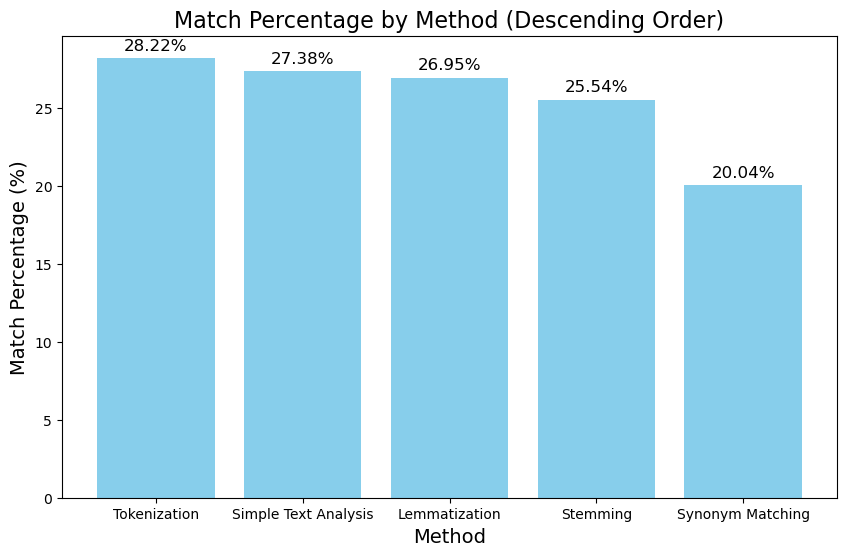

In [15]:
import matplotlib.pyplot as plt

# Data for the bar graph
methods = ['Simple Text Analysis', 'Tokenization', 'Synonym Matching', 'Lemmatization', 'Stemming']
match_percentages = [27.38, 28.22, 20.04, 26.95, 25.54]

# Combine methods and match percentages into a list of tuples
combined_data = list(zip(match_percentages, methods))

# Sort the data in descending order by match percentage
sorted_data = sorted(combined_data, reverse=True)

# Unzip the sorted data
sorted_percentages, sorted_methods = zip(*sorted_data)

# Create the bar graph
plt.figure(figsize=(10, 6))
plt.bar(sorted_methods, sorted_percentages, color='skyblue')

# Adding title and labels
plt.title('Match Percentage by Method (Descending Order)', fontsize=16)
plt.xlabel('Method', fontsize=14)
plt.ylabel('Match Percentage (%)', fontsize=14)

# Displaying the percentage on top of each bar
for i, percentage in enumerate(sorted_percentages):
    plt.text(i, percentage + 0.5, f'{percentage:.2f}%', ha='center', fontsize=12)

# Show the plot
plt.show()


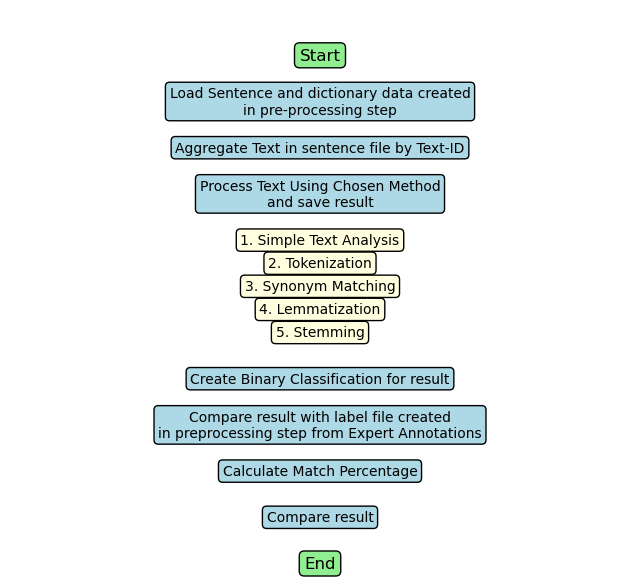

In [19]:
import matplotlib.pyplot as plt

# Create a simple flowchart using text
fig, ax = plt.subplots(figsize=(8, 6))

# Start
ax.text(0.5, 0.9, "Start", ha='center', va='center', fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightgreen"))

# Load data
ax.text(0.5, 0.8, "Load Sentence and dictionary data created\nin pre-processing step", ha='center', va='center', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightblue"))

# Aggregate text
ax.text(0.5, 0.7, "Aggregate Text in sentence file by Text-ID", ha='center', va='center', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightblue"))

# Process text using chosen method
ax.text(0.5, 0.6, "Process Text Using Chosen Method\nand save result", ha='center', va='center', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightblue"))

# List of methods
methods = ["1. Simple Text Analysis", "2. Tokenization", "3. Synonym Matching", "4. Lemmatization", "5. Stemming"]
for i, method in enumerate(methods):
    ax.text(0.5, 0.5-(i*0.05), method, ha='center', va='center', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightyellow"))

# Create Binary Classification
ax.text(0.5, 0.2, "Create Binary Classification for result", ha='center', va='center', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightblue"))

# Compare with label file
ax.text(0.5, 0.1, "Compare result with label file created\nin preprocessing step from Expert Annotations", ha='center', va='center', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightblue"))

# Calculate Match Percentage
ax.text(0.5, 0.0, "Calculate Match Percentage", ha='center', va='center', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightblue"))

# Compare result
ax.text(0.5, -0.1, "Compare result", ha='center', va='center', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightblue"))

# End
ax.text(0.5, -0.2, "End", ha='center', va='center', fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightgreen"))

ax.axis('off')

plt.show()
